# Project: AI Photo Editing with Inpainting

This notebook is based on the provided [starter.ipynb](Udacity-Provided-Workspace/Computer-Vision-and-Generative-AI-Project/starter/starter.ipynb) Jupyter notebook. I've modified the notebook slightly to clean up the code and remove instructions.

In [ ]:
import numpy as np
import requests
import torch

from diffusers import (
    AutoPipelineForInpainting,
    AutoPipelineForText2Image, 
    DiffusionPipeline
)
from diffusers.utils import load_image, make_image_grid
from PIL import Image
from transformers import SamModel, SamProcessor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## SAM

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

## Get the segmentation mask

In [ ]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent


def get_processed_inputs(image, input_points):
    # Generate model inputs
    inputs = processor(
        raw_image,
        input_points=input_points,
        return_tensors="pt"
    ).to(device)
    
    # Call SAM
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Now let's post process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Here we select the mask with the highest score
    # as the mask we will use. You can experiment with also
    # other selection criteria, for example the largest mask
    # instead of the most confident mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 

    # NOTE: we invert the mask by using the ~ operator because
    # so that the subject pixels will have a value of 0 and the
    # background pixels a value of 1. This will make it more convenient
    # to infill the background
    return ~best_mask.cpu().numpy()

In [ ]:
# Open the image of the car and **we resize it to 512 by 512 pixels** (a square image).
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

# Generate the mask using our function
mask = get_processed_inputs(raw_image, input_points)

# Display result
Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

## Inpainting

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

In [ ]:
def inpaint(
    raw_image,             # Raw image
    input_mask,            # Input mask generated by SAM
    prompt,                # Text prompt for infill
    negative_prompt=None,  # Negative prompt
    seed=74294536,         # Seed
    cfgs=7                 # Classifier-Free Guidance Scale
):
    mask_image = Image.fromarray(input_mask)
    
    rand_gen = torch.manual_seed(seed)
    
    # Use the pipeline we have created in the previous cell
    # Use "prompt" as prompt, 
    # "negative_prompt" as the negative prompt,
    # raw_image as the image,
    # mask_image as the mask_image,
    # rand_gen as the generator and
    # cfgs as the guidance_scale
    image = pipeline(
        image=raw_image,
        mask_image=mask_image,
        seed=seed,
        generator=rand_gen,
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=cfgs
    ).images[0]
    
    return image

In [ ]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

Let's have a look at what we have produced:

In [ ]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

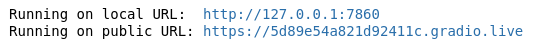

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:   then **execute the next cell containing the code `my_app.close`**


In [ ]:
import app

In [ ]:
my_app = app.generate_app(get_processed_inputs, inpaint)

In [ ]:
my_app.close()